# Visualize cumulative contibution by user over time for the [Deep Review](https://github.com/greenelab/deep-review)

Derived from [`rephetio-rviz.ipynb`](https://github.com/dhimmel/thinklytics/blob/ea8569e0e2aa5a15be34143b9a91fc4b3685c4cf/viz/rephetio-rviz.ipynb)

In [42]:
library(magrittr)

## Read datasets

In [43]:
commit_df = readr::read_tsv('commits.tsv',  col_types = "ccccDccddcdddd" ) %>%
  dplyr::arrange(authored_datetime) %>%
  dplyr::filter(merge == 0) %>%
  dplyr::filter(characters_added != 0 | characters_deleted != 0) %>%
  dplyr::rename(username=author_name, date=authored_datetime)
  #dplyr::select(project, profile_id, username, first_name, last_name)
head(commit_df, 2)
print(commit_df)

Warning message:
“123 parsing failures.
row               col   expected    actual          file
 92 NA                14 columns 7 columns 'commits.tsv'
 93 authored_datetime date like  11        'commits.tsv'
 93 NA                14 columns 8 columns 'commits.tsv'
101 NA                14 columns 7 columns 'commits.tsv'
102 authored_datetime date like  0         'commits.tsv'
... ................. .......... ......... .............
See problems(...) for more details.
”

commit,username,author_email,committer_name,date,committed_datetime,summary,count,merge,parents,words_added,words_deleted,characters_added,characters_deleted
<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
3f8cdd531916e7cfb3a295f53142c6930ad5c124,Halie Rando,halie.rando@pennmedicine.upenn.edu,Halie Rando,2020-03-20,2020-03-20 15:18:05-04:00,initial commit,316,0,1780fac0ac6bba1260a9da3886061730fa5d2765,146,0,1000,0
02b07f0f32bdcd7075dde7370bb08e6e36d908a1,Halie Rando,halie.rando@pennmedicine.upenn.edu,Halie Rando,2020-03-20,2020-03-20 18:11:40-04:00,updated readme and abstract,317,0,3f8cdd531916e7cfb3a295f53142c6930ad5c124,85,61,630,414


# A tibble: 2,509 x 14
   commit username author_email committer_name date       committed_datet…
   <chr>  <chr>    <chr>        <chr>          <date>     <chr>           
 1 3f8cd… Halie R… halie.rando… Halie Rando    2020-03-20 2020-03-20 15:1…
 2 02b07… Halie R… halie.rando… Halie Rando    2020-03-20 2020-03-20 18:1…
 3 b9254… Halie R… halie.rando… GitHub         2020-03-21 2020-03-21 08:3…
 4 b0638… Halie R… halie.rando… GitHub         2020-03-21 2020-03-21 08:3…
 5 be27f… Halie R… halie.rando… Halie Rando    2020-03-21 2020-03-21 09:1…
 6 00338… Halie R… halie.rando… Halie Rando    2020-03-21 2020-03-21 12:1…
 7 78994… Casey G… greenescien… Casey Greene   2020-03-22 2020-03-22 11:3…
 8 3b15c… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
 9 d2489… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
10 cbd85… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
# … with 2,499 more rows, and 8 more variables: summary <chr>, count <dbl>,
#

## Create a dataframe where each row is the cumulative contribution of a user at a given datetime

In [44]:
cumulative_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::mutate(cum_words = cumsum(words_added)) %>% 
  dplyr::mutate(cum_chars = cumsum(characters_added)) %>%
  dplyr::ungroup() %>%
  dplyr::select(username, date, cum_words, cum_chars)

cumulative_df %>% head(2)

username,date,cum_words,cum_chars
<chr>,<date>,<dbl>,<dbl>
Halie Rando,2020-03-20,146,1000
Halie Rando,2020-03-20,231,1630


In [45]:
min_date = as.Date(min(cumulative_df$date))
max_date = as.Date(max(cumulative_df$date))
#six_months = lubridate::duration(6, 'months')

even_date_df = dplyr::tibble(username = 'rando2', 
                             date = seq.Date(min_date, max_date, by='day'))
cumulative_df = dplyr::bind_rows(
  cumulative_df %$%
    dplyr::tibble(username = unique(username), date=min_date, cum_words=0, cum_chars=0),
  cumulative_df,
  cumulative_df %>%
    dplyr::group_by(username) %>%
    dplyr::summarize(date=max_date, cum_words = max(cum_words), cum_chars = max(cum_chars))
  ) %>%
  dplyr::full_join(even_date_df) %>%
  tidyr::complete(username, date) %>%
  tidyr::fill(username, cum_words, cum_chars) %>%
  dplyr::filter(as.Date(date) %in% as.Date(even_date_df$date)) %>% 
  dplyr::distinct()

cumulative_df %>% tail(10)

Joining, by = c("username", "date")


username,date,cum_words,cum_chars
<chr>,<date>,<dbl>,<dbl>
Yusha Sun,2021-04-17,351,3561
Yusha Sun,2021-04-18,351,3561
Yusha Sun,2021-04-19,351,3561
Yusha Sun,2021-04-20,351,3561
Yusha Sun,2021-04-21,351,3561
Yusha Sun,2021-04-22,351,3561
Yusha Sun,2021-04-23,351,3561
Yusha Sun,2021-04-24,351,3561
Yusha Sun,2021-04-25,351,3561


## Create a dataframe of users

In [46]:
# transformation = sqrt
transformation = identity

In [57]:
get_colors = colorRampPalette(RColorBrewer::brewer.pal(12, 'Paired'))

usage_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::summarize(
    first_date = min(date),
    total_chars = sum(characters_added),
    total_words = sum(words_added),
    total_chars_trans = transformation(total_chars)
  ) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(first_date) %>%
  dplyr::mutate(y_position = cumsum(total_chars_trans) - total_chars_trans / 2) %>%
  dplyr::mutate(color = get_colors(length(username)))

usage_df$username = factor(usage_df$username, levels = usage_df$username)

# If a user appears twice here, fix that manually in above
usage_df %>%
  dplyr::select(username, first_date, total_chars, total_words) %>%
  readr::write_tsv('contributors.tsv')

usage_df %>% head(3)

username,first_date,total_chars,total_words,total_chars_trans,y_position,color
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Halie Rando,2020-03-20,1404558,178567,1404558,702279,#A6CEE3
Casey Greene,2020-03-22,300891,41177,300891,1555004,#80B6D6
Michael Robson,2020-03-23,969,38,969,1705934,#5B9EC9


## Create a smoothed dataframe of cumulative contribution

In [100]:
min_date_decimal = min(commit_df$date) %>% lubridate::decimal_date()
max_date_decimal = max(commit_df$date) %>% lubridate::decimal_date()
constant = nrow(even_date_df) / diff(lubridate::decimal_date(range(even_date_df$date)))

densify = function(df) {
  den = suppressWarnings(density(
    df$date %>% lubridate::decimal_date(),
    weights = df$cum_chars, bw=0.025,
    from = min_date_decimal, to = max_date_decimal))
  dplyr::tibble(date = lubridate::date_decimal(den$x), cum_chars = den$y / constant) %>% return
}

smooth_df = cumulative_df %>%
  dplyr::group_by(username) %>%
  dplyr::do(densify(.)) %>%
  dplyr::mutate(cum_chars_trans = transformation(cum_chars)) %>%
  dplyr::ungroup()

smooth_df$username = factor(smooth_df$username, levels = usage_df$username)

smooth_df %<>% dplyr::arrange(username, date)
smooth_df %>% head(2)

username,date,cum_chars,cum_chars_trans
<fct>,<dttm>,<dbl>,<dbl>
Halie Rando,2020-03-19 23:59:59,54078.28,54078.28
Halie Rando,2020-03-20 18:53:43,58906.04,58906.04


## Plot contribution by rank over time

In [120]:
# THIS CURRENTLY DOES NOT CREATE A USABLE FIGURE. Recommended to skip to next section.
# Load tsv of names with positions (names copied from contributors.tsv)
# I had to use a manual edit to drop the additions associated with the creation of the repository, since
# it wouldn't let me filter by date easily!

position_df = readr::read_tsv('positions.tsv') %>%
  dplyr::left_join(usage_df, position_df, 
              by = c("username")) %>%
  dplyr::group_by(first_date, position) %>%
  dplyr::summarize(total_words = sum(total_words, na.rm = TRUE)) %>%
  dplyr::filter(total_words != 178567)

print(position_df)

Parsed with column specification:
cols(
  username = col_character(),
  position = col_character()
)
Warning message:
“Column `username` joining character vector and factor, coercing into character vector”

# A tibble: 38 x 3
# Groups:   first_date [30]
   first_date position     total_words
   <date>     <chr>              <dbl>
 1 2020-03-22 faculty (sr)       41177
 2 2020-03-23 faculty (jr)          38
 3 2020-03-23 grad student          58
 4 2020-03-24 grad student        5274
 5 2020-03-25 faculty (jr)         681
 6 2020-03-25 post-doc           24156
 7 2020-03-26 faculty (jr)        7460
 8 2020-03-26 post-doc            5246
 9 2020-03-28 faculty (sr)         711
10 2020-03-30 faculty (jr)        1815
# … with 28 more rows


In [121]:
label_df = position_df%>%
  dplyr::mutate(date = max_date) %>%
  dplyr::mutate(name_label = position) %>%
  dplyr::mutate(nword_label = sprintf('%.1fK ', total_words / 1000)) %>%
  dplyr::mutate(color = get_colors(length(position)))

label_df %<>% dplyr::filter(total_words>= 9000)
label_df %>% head(20)

first_date,position,total_words,date,name_label,nword_label,color
<date>,<chr>,<dbl>,<date>,<chr>,<chr>,<chr>
2020-03-22,faculty (sr),41177,2021-04-26,faculty (sr),41.2K,#A6CEE3
2020-03-25,post-doc,24156,2021-04-26,post-doc,24.2K,#B15928
2020-05-13,faculty (sr),13854,2021-04-26,faculty (sr),13.9K,#A6CEE3
2020-05-13,other,67664,2021-04-26,other,67.7K,#B15928


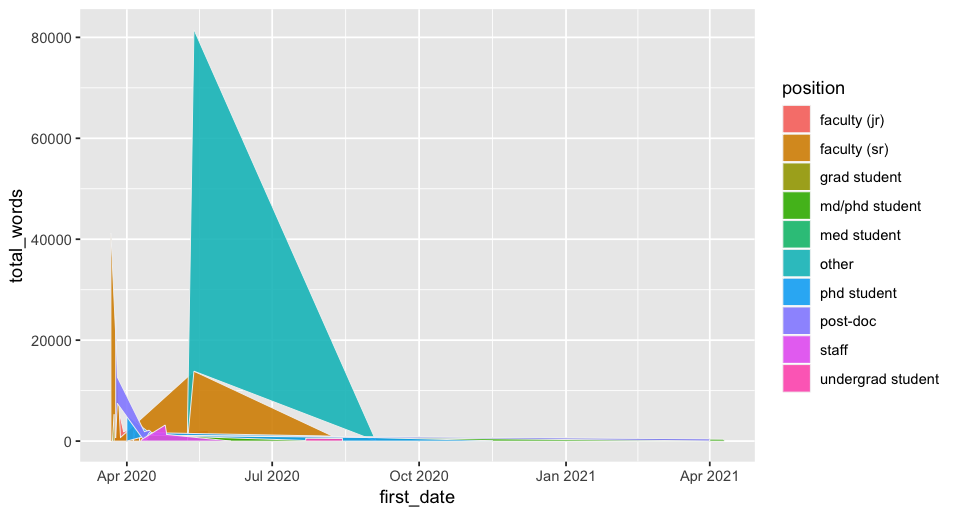

In [122]:
# Set figure dimensions
width = 8
height = 4.3
options(repr.plot.width=width, repr.plot.height=height)

project_start = as.Date("2020-03-20", "%Y-%m-%d")

major_breaks = seq(project_start, max_date, by = "3 months")
minor_breaks = seq(project_start, max_date, by = "1 months")
light_black = '#282828'

gg = position_df %>%
  ggplot2::ggplot(ggplot2::aes(x = first_date)) +
  ggplot2::geom_area(ggplot2::aes(y = total_words, fill = position), 
            alpha = 0.9, size = 0.27, colour = "grey95",
            position=ggplot2::position_stack(reverse = TRUE)) #+
#  ggplot2::geom_text(data = label_df,
#    mapping = ggplot2::aes(y = y_position, label=name_label, color=username), size = 4, hjust = 0) #+
#  ggplot2::geom_text(data = label_df,
#    mapping = ggplot2::aes(y = y_position, label=nchar_label), size = 4, hjust = 1, color=light_black) +
#  ggplot2::theme_minimal() +
#  ggplot2::guides(colour = "none", fill = "none") +
#  ggplot2::scale_x_datetime(date_labels = '%b %Y', breaks = major_breaks, minor_breaks = minor_breaks,
#    limits = c(min_date - lubridate::period(1, 'day'), max_date + (max_date - min_date) / 4.92)) #+
#  ggplot2::scale_y_continuous(breaks = NULL, minor_breaks = NULL, labels = NULL, expand = c(0, 0)) +
#  ggplot2::scale_fill_manual(values = usage_df$color) + 
#  ggplot2::scale_color_manual(values = label_df$color) + 
#  ggplot2::theme(
#    axis.title.y = ggplot2::element_text(color = light_black, margin=ggplot2::margin(0,-9,0,0)),
#    axis.ticks.x = ggplot2::element_line(size = 0.4, color = light_black),
#    axis.text.x = ggplot2::element_text(color = light_black),
#    axis.ticks.length = grid::unit(0.1, "cm"),
#    panel.grid.major.x = ggplot2::element_line(colour = "grey70"),
#    panel.grid.minor.x = ggplot2::element_line(colour = "grey98"),
#    plot.margin = ggplot2::margin(t=6, r=2, b=2, l=2, unit='pt')) +
#  ggplot2::labs(x = NULL, y = expression(sqrt(Total~Characters)))
#  ggplot2::labs(x = NULL, y = 'Total Characters')

gg

In [24]:
# Save image to file
ggplot2::ggsave(gg, filename = 'deep-review-contribution.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'deep-review-contribution.pdf', width = width, height = height, bg = 'transparent')

## Total words added ridgeline plot

In [125]:
total_words_stairstep <- function(df) {
  df = df %>% dplyr::transmute(x = date, y = words_added)
  init_df = dplyr::tibble(x = min(df$x), y = 0)
  stop_df = dplyr::tibble(x = max_date, y = 0)
  df = dplyr::bind_rows(init_df, df, stop_df) %>%
    dplyr::mutate(y = cumsum(y)) %>%
    ggplot2:::stairstep(direction="hv") %>%
    dplyr::distinct() %>%
    dplyr::rename(date = x, total_words = y)
  return(df)
}

total_words_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::do(total_words_stairstep(.)) %>%
  dplyr::ungroup()

total_words_df %>% head()

username,date,total_words
<chr>,<date>,<dbl>
Adam MacLean,2020-03-30,0
Adam MacLean,2020-03-30,23
Adam MacLean,2020-03-30,496
Adam MacLean,2020-03-30,509
Adam MacLean,2020-03-30,867
Adam MacLean,2020-03-30,883


In [126]:
y_labels = usage_df %$%
  sprintf('%s (+%s)', username, formatC(total_words, big.mark=',', format='d')) %>%
  setNames(usage_df$username)

usernames = as.character(usage_df$username)
usernames = c(usernames[1], '', usernames[2], '', usernames[3:nrow(usage_df)])

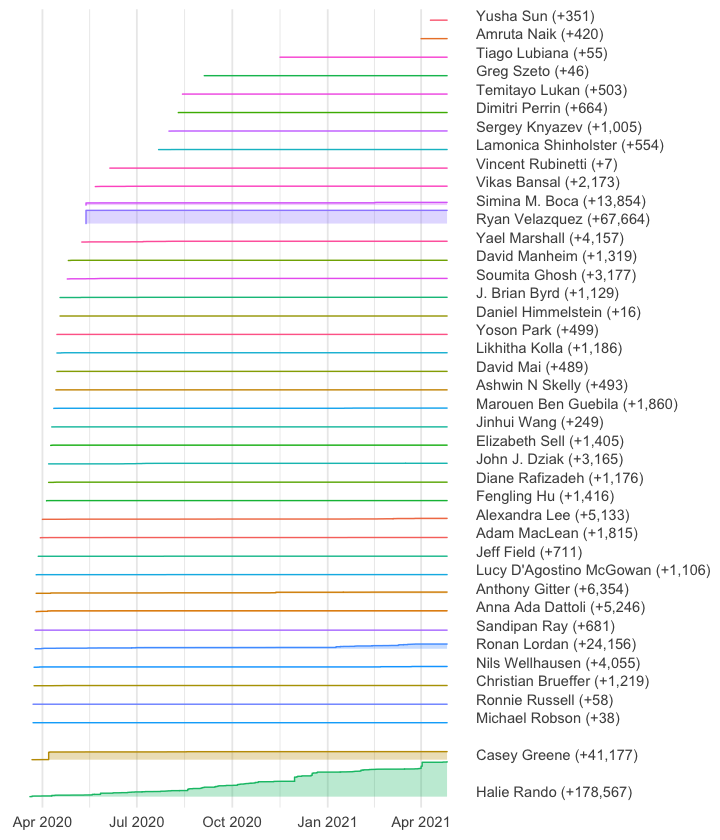

In [127]:
# Set figure dimensions
width = 6
height = 7
options(repr.plot.width=width, repr.plot.height=height)

gg = total_words_df %>%
  ggplot2::ggplot(ggplot2::aes(x = date, y = username, height = total_words, group = username, 
                               fill=username, color=username)) +
  ggridges::geom_density_ridges(stat='identity', size=0.4, alpha=0.3) +
#  ggplot2::scale_x_datetime(expand = c(0, 0), date_labels = '%b %Y', breaks = major_breaks, 
#                            minor_breaks = minor_breaks) +
  ggplot2::scale_y_discrete(limits=usernames, position = 'right', labels=y_labels) +
  #ggplot2::scale_fill_manual(values = setNames(usage_df$color, usage_df$username)) +
  ggplot2::guides(fill=FALSE, color=FALSE) +
  ggplot2::xlab(NULL) +
  ggplot2::ylab(NULL) +
  ggplot2::theme_minimal() +
  ggplot2::theme(axis.text.y = ggplot2::element_text(vjust = 0)) +
  ggplot2::theme(panel.grid.major.y = ggplot2::element_blank())

gg

In [129]:
# Save image to file
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-ridge.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-ridge.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-ridge.pdf', width = width, height = height, bg = 'transparent')

## Create a monthly commit summary dataframe

In [130]:
month_df = commit_df %>%
  dplyr::mutate(year_month=substr(date, 0, 7)) %>%
  tidyr::gather('diff_type', 'count', words_added:characters_deleted) %>%
  dplyr::group_by(username, year_month, diff_type) %>%
  dplyr::summarize(
    count = sum(count)
  ) %>%
  dplyr::ungroup()
month_df %>% head(3)

username,year_month,diff_type,count
<chr>,<chr>,<chr>,<dbl>
Adam MacLean,2020-03,characters_added,8553
Adam MacLean,2020-03,characters_deleted,3076
Adam MacLean,2020-03,words_added,1051


### Visualize contribution by month

In [131]:
# Create year_month breaks to gaurantee no missing months
`%m+%` = lubridate::`%m+%`
year_month_breaks = format(seq(min(commit_df$date), max(commit_df$date) %m+% months(1), by = "month"), "%Y-%m")


year_month_labeler = function(year_month) {
  # Function to return axis labels for every third year_month
  date_ = lubridate::ymd(year_month, truncated = 1)
  month_ = lubridate::month(date_)
  if (month_ %% 3 == 1) {
    return(format(date_, "%b %Y"))
  }
  return("")
}
year_month_labeler = Vectorize(year_month_labeler)

# diff_type colors
diff_type_colors = c(
  words_added = '#28A745',
  words_deleted = '#CB2431'
)

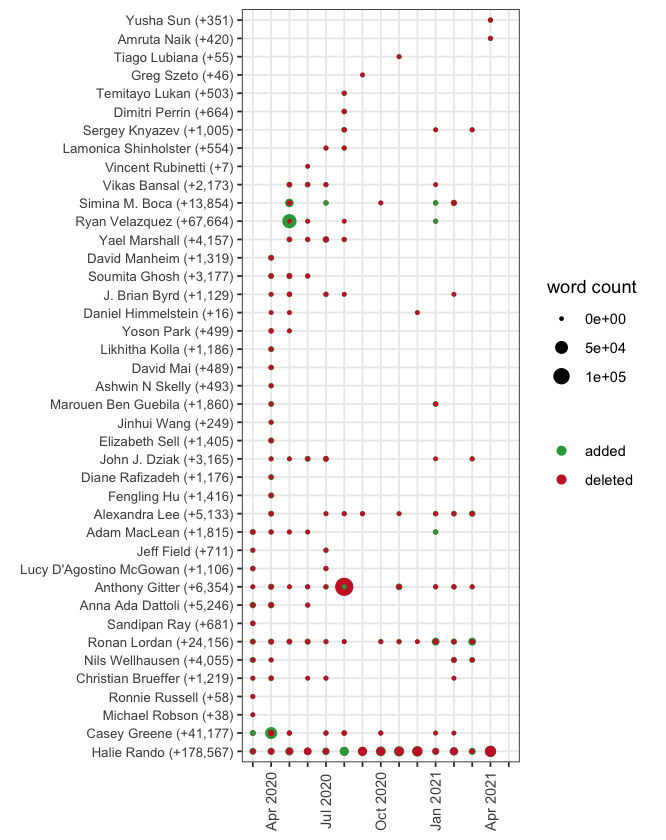

In [132]:
# Set figure dimensions
width = 5.55
height = 7
options(repr.plot.width=width, repr.plot.height=height)

gg = month_df %>%
  dplyr::filter(diff_type %in% c('words_added', 'words_deleted')) %>%
  dplyr::arrange(desc(count), desc(diff_type)) %>%
  ggplot2::ggplot(ggplot2::aes(x=year_month, y = username, size = count, color=diff_type)) +
  ggplot2::geom_point(stroke=1) +
  ggplot2::scale_y_discrete(limits=usage_df$username, position = 'top', labels=y_labels, name=NULL) +
  ggplot2::scale_x_discrete(limits = year_month_breaks, labels=year_month_labeler, name=NULL) +
  ggplot2::scale_size_area(max_size = 3.8, name='word count') +
  ggplot2::scale_color_manual(values=diff_type_colors, name=NULL, labels=c('added', 'deleted')) +
  ggplot2::coord_fixed() +
  ggplot2::theme_bw() +
  ggplot2::theme(
    axis.text.x = ggplot2::element_text(angle = 90, vjust = 0.5),
    axis.text.y = ggplot2::element_text(size=8))

gg

In [133]:
# Save image to file
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.pdf', width = width, height = height, bg = 'transparent')

## Summary statistics

In [134]:
min_date
max_date
max_date - min_date

[1] "2020-03-20"

[1] "2021-04-26"

Time difference of 402 days

## Package information

In [135]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS/LAPACK: /Users/halierando/opt/miniconda3/envs/contrib-viz/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] gdtools_0.1.7  bindrcpp_0.2.2 magrittr_1.5  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6       plyr_1.8.6         pillar_1.4.3       compiler_3.5.1    
 [5] RColorBrewer_1.1-2 bindr_0.1.1        base64enc_0.1-3    tools_3.5.1       
 [9] digest_0.6.25      uuid_0.1-4         gtable_0.3.0       jsonlite_1.6.1    
[13] lubridate_1.7.4    evaluate_0.14      lifecycle_1.0.0    tibble_3.0.1      
[17] pkgconfig_2.0.3    rlang_0.4.10       IRdisplay_0.7.0    cli_2.0.2         
[21] IRkernel_0.8.15    repr_1.1.0         dplyr_1.0.5        stringr_1.4.0     
[25] 